In [41]:
# !pip install gymnasium renderlab
# !pip install opencv-python
# !pip install pygame

In [64]:
import gymnasium as gym
import random
from IPython.display import clear_output
%config NotebookApp.iopub_msg_rate_limit=10000
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [65]:
qLearningData = pd.read_csv('Q-LearningData.csv')
sarsaData = pd.read_csv('SarsaData.csv')

In [78]:
#visualise maze:
rfpMaze = ["SFFF", "FHHH", "FFFF", "HFHF", "FFGF"]
maze1 = ["SFFH", "FHHF", "FHFG", "FFFH", "HFHH"]

desc = rfpMaze
mazeSize = [len(desc),len(desc[0])]

statePositions = [[] for _ in range(mazeSize[0])]
stateNum = 0
for i in range(mazeSize[0]):
    for j in range(mazeSize[1]):
        statePositions[i].append(stateNum)
        stateNum += 1
        

        
giftState = -1
gift_found = False
for i in range(len(desc)):
    if gift_found:
        break
    for j in range(len(desc[i])):
        giftState += 1
        if desc[i][j] == 'G':
            gift_found = True
            break
            
print(giftState)
print(statePositions)

env = gym.make('FrozenLake-v1', desc=desc, map_name="5x5", is_slippery=False, render_mode="human") 

18
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19]]


In [45]:
qTable_1 = {}
def resetTable():
    global qTable_1
    qTable_1 = {}
    for i in range(mazeSize[0]*mazeSize[1]):
        qTable_1[i] = [0,0,0,0] 
    global currentState
    currentState = 0
    
def getPosition(state):
    for i in range(len(statePositions)):
        for j in range(len(statePositions[i])):
            if statePositions[i][j] == state:
                return i, j
            
def calcReward(state, nextState):
    y1, x1 = getPosition(state)
    y2, x2 = getPosition(nextState)
    y3, x3 = getPosition(giftState)
    
    currentDist = (((y3 - y1)**2)+((x3 - x1)**2))**0.5
    nextDist = (((y3 - y2)**2)+((x3 - x2)**2))**0.5
    
    changeInDist = currentDist-nextDist
    return changeInDist/2

def calcPossibleMoves(state):
    global qTable_1
    possibleMoves = []
    
    if state == 0:
        return [1,2]
    
    if (state+1) % mazeSize[1] != 0:
        possibleMoves.append(2)
        
    if (state+1) % mazeSize[1] != 1:
        possibleMoves.append(0)
        
    if state > (mazeSize[1]-1):
        possibleMoves.append(3)
    
    if state < ((mazeSize[0] * mazeSize[1]) - mazeSize[1]):
        possibleMoves.append(1)
        
    return possibleMoves

def nextStep(state):
    global qTable_1
    possMoves = calcPossibleMoves(state)
    
    if random.random() < epsilonValue:
        nextMove = random.choice(possMoves)
    else:
        qValues = {}
        for move in possMoves:
            qValues[move] = qTable_1[state][move]

        maxValue = max(qValues.values())
        minValue = min(qValues.values())
        count_max = sum(1 for value in qValues.values() if value == maxValue)
        count_min = sum(1 for value in qValues.values() if value == minValue)

        if count_max > 1 and count_max < len(possMoves):
            nextMove = random.choice([move for move in possMoves if qValues[move] != minValue])
        elif count_max == len(possMoves):
            nextMove = random.choice(possMoves)
        else:
            nextMove = max(qValues, key=qValues.get)
    return nextMove

def pathFound():
    currentState = 0
    for i in range(mazeSize[0]*mazeSize[1]-1):
        bestDirection = None
        if max(qTable_1[currentState]) > 0:
            bestDirection = qTable_1[currentState].index(max(qTable_1[currentState]))
        newState = 0
        if bestDirection == 0 and 0 in calcPossibleMoves(currentState):
            newState = currentState - 1
        elif bestDirection == 1 and 1 in calcPossibleMoves(currentState):
            newState = currentState + mazeSize[1]
        elif bestDirection == 2 and 2 in calcPossibleMoves(currentState):
            newState = currentState + 1
        elif bestDirection == 3 and 3 in calcPossibleMoves(currentState):
            newState = currentState - mazeSize[1]

        if newState == giftState:
            return True
        currentState = newState
    return False

timesVisited = {}
def resetVisited():
    global timesVisited
    timesVisited = {}
    for i in range(mazeSize[0]*mazeSize[1]):
        timesVisited[i] = 0

def updateTable_qLearning(direction, nextState, reward):
    global qTable_1
    global currentState
    didConverge = False
    updated = qTable_1[currentState][direction] + alpha*(reward + (max(qTable_1[nextState])) - qTable_1[currentState][direction])
    changeInQ = round(abs(qTable_1[currentState][direction] - updated),5)
    if changeInQ < convergenceThresh:
        if changeInQ > 0 and pathFound():
            didConverge = True
    qTable_1[currentState][direction] = updated
    timesVisited[currentState] += 1
    currentState = nextState
    return didConverge, changeInQ

def updateTable_sarsa(direction, nextState, reward):
    global qTable_1
    global currentState
    didConverge = False
    nextDirection = nextStep(nextState)
    updated = qTable_1[currentState][direction] + alpha*(reward + (qTable_1[nextState][nextDirection]) - qTable_1[currentState][direction])
    changeInQ = round(abs(qTable_1[currentState][direction] - updated),5)
    if changeInQ < convergenceThresh:
        if changeInQ > 0 and pathFound():
            didConverge = True
    qTable_1[currentState][direction] = updated
    timesVisited[currentState] += 1
    currentState = nextState
    return didConverge, changeInQ, nextDirection

def updateTable_monteCarlo(steps, totalReward):
    global qTable_1
    global currentState
    global direction
    minChangeInQ = 0
    didConverge = False
    avgReward = totalReward/len(steps)
    for i in range(len(steps)):
        updated = qTable_1[steps[i][0]][steps[i][1]] + alpha*(avgReward-qTable_1[steps[i][0]][steps[i][1]])
        changeInQ = round(abs(qTable_1[currentState][direction] - updated),5)
        if i == 0:
            minChangeInQ = changeInQ
        elif changeInQ < minChangeInQ and changeInQ != 0:
            minChangeInQ = changeInQ
        if changeInQ < convergenceThresh:
            if changeInQ > 0 and pathFound():
                didConverge = True
        qTable_1[steps[i][0]][steps[i][1]] = updated
    timesVisited[currentState] += 1
    return didConverge, minChangeInQ

In [72]:
epsilonValue = 0.35
alpha = 0.65
convergenceThresh = 0.01
revistPenalty = -0.25
totalTrials = 0

In [73]:
#Q LEARNING-----------------------------------------------------------------------

def qLearning(trialType, maxEpisodes, currentTrial):
    global currentState
    global revisitPenalty
    global totalTrials
    global totalTime_start
    
    currentState = 0
    currentEpisode = 1
    converged = False
    
    resetVisited()
    resetTable()
    env.reset()
    
    start_time = time.time()
    
    while currentEpisode <= maxEpisodes:
        if converged:
            break

        direction = nextStep(currentState)
        nextState, reward, terminated, truncated, info = env.step(direction)
        
        if trialType == 0:
            if terminated:
                if not reward < 1:
                    reward = 10
        elif trialType == 1:
            if terminated:
                if reward < 1:
                    reward = -1
                else:
                    reward = 10
            if not terminated:
                reward = calcReward(currentState, nextState)
                if timesVisited[nextState] > 0:
                    reward += revistPenalty*timesVisited[nextState]

        converged, changeInQ = updateTable_qLearning(direction, nextState, reward)

        if terminated or truncated or converged:
            observation, info = env.reset()
            currentState = 0
            if not converged:
                currentEpisode += 1
                resetVisited()


        if converged:
            end_time = time.time()
        
        clear_output(wait=True)
        if totalTrials != 0:
            print("Trial: " + 'Q-Learning, ' + 'trialType '+ str(trialType) + ', Trial ' + str(currentTrial) + "/" + str(totalTrials))
        print("Episode: " + str(currentEpisode) + "/" + str(maxEpisodes))
        print("Trial Time: " + str(round(time.time()-start_time, 3)) + " sec")
        if totalTrials != 0:
            print("Total Time: " + str(round((time.time()-totalTime_start)/60, 3)) + " min")
        print("Q-Table:")
        for i in range(len(qTable_1)):
            print(str(i) + ": " + str(qTable_1[i]))
        print("change in Q: " + str(changeInQ))
        
    duration = 0
    if converged:
        duration = end_time - start_time
        print(str(round(duration, 3)) + " seconds to converge")
    else:
        duration = None
        print("No convergence")
        
    return (currentEpisode-1), duration

In [74]:
#SARSA-----------------------------------------------------------------------

def sarsa(trialType, maxEpisodes, currentTrial):
    global currentState
    global revisitPenalty
    global totalTrials
    global totalTime_start
    
    currentState = 0
    currentEpisode = 1
    converged = False
    startOfEpisode = True
    direction = None

    resetVisited()
    resetTable()
    env.reset()
    
    start_time = time.time()
    while currentEpisode <= maxEpisodes:
        if converged:
            break

        if startOfEpisode:
            direction = nextStep(currentState)
            startOfEpisode = False
        nextState, reward, terminated, truncated, info = env.step(direction)

        if trialType == 0:
            if terminated:
                if not reward < 1:
                    reward = 10
        elif trialType == 1:
            if terminated:
                if reward < 1:
                    reward = -1
                else:
                    reward = 10
            if not terminated:
                reward = calcReward(currentState, nextState)
                if timesVisited[nextState] > 0:
                    reward += revistPenalty*timesVisited[nextState]

        converged, changeInQ, nextDirection = updateTable_sarsa(direction, nextState, reward)
        direction = nextDirection

        if terminated or truncated or converged:
            observation, info = env.reset()
            currentState = 0
            if not converged:
                currentEpisode += 1
                startOfEpisode = False
                resetVisited()


        if converged:
            end_time = time.time()

        clear_output(wait=True)
        if totalTrials != 0:
            print("trial: " + 'SARSA, ' + 'trialType '+ str(trialType) + ', Trial ' + str(currentTrial) + "/" + str(totalTrials))
        print("Episode: " + str(currentEpisode) + "/" + str(maxEpisodes))
        print("Trial Time: " + str(round(time.time()-start_time, 3)) + " sec")
        if totalTrials != 0:
            print("Total Time: " + str(round((time.time()-totalTime_start)/60, 3)) + " min")
        print("Q-Table:")
        for i in range(len(qTable_1)):
            print(str(i) + ": " + str(qTable_1[i]))
        print("change in Q: " + str(changeInQ))

    duration = 0
    if converged:
        duration = end_time - start_time
        print(str(round(duration, 3)) + " seconds to converge")
    else:
        duration = None
        print("No convergence")
        
    return (currentEpisode-1), duration

In [75]:
# Monte Carlo -----------------------------------------------------------------------

def monteCarlo(trialType, maxEpisodes, currentTrial):
    global currentState
    global revisitPenalty
    global direction
    global totalTrials
    global totalTime_start
    
    currentEpisode = 1
    converged = False

    episodeSteps = []
    totalReward = 0

    resetVisited()
    resetTable()
    env.reset()
    
    start_time = time.time()
    
    while currentEpisode <= maxEpisodes:
        global currentState
        if converged:
            break

        direction = nextStep(currentState)
        episodeSteps.append([currentState, direction])
        nextState, reward, terminated, truncated, info = env.step(direction)

        if trialType == 0:
            if terminated:
                if not reward < 1:
                    reward = 10
        elif trialType == 1:
            if terminated:
                if reward < 1:
                    reward = -1
                else:
                    reward = 10
            if not terminated:
                reward = calcReward(currentState, nextState)
                if timesVisited[nextState] > 0:
                    reward += revistPenalty*timesVisited[nextState]

        totalReward += reward
        currentState = nextState

        changeQ = 0
        if terminated or truncated:
            observation, info = env.reset()
            converged, changeInQ = updateTable_monteCarlo(episodeSteps, totalReward)
            changeQ = changeInQ
            episodeSteps = []
            currentState = 0
            currentEpisode += 1
            resetVisited()
            
        clear_output(wait=True)
        if totalTrials != 0:
            print("trial: " + 'Monte Carlo, ' + 'trialType '+ str(trialType) + ', Trial ' + str(currentTrial) + "/" + str(totalTrials))
        print("Episode: " + str(currentEpisode) + "/" + str(maxEpisodes))
        print("Current Path: " + str(episodeSteps))
        print("Trial Time: " + str(round(time.time()-start_time, 3)) + " sec")
        if totalTrials != 0:
            print("Total Time: " + str(round((time.time()-totalTime_start)/60, 3)) + " min")
        print("Q-Table:")
        for i in range(len(qTable_1)):
            print(str(i) + ": " + str(qTable_1[i]))
        print("change in Q: " + str(changeQ))

        if converged:
            end_time = time.time()
            observation, info = env.reset()

    duration = 0
    if converged:
        duration = end_time - start_time
        print(str(round(duration, 3)) + " seconds to converge")
    else:
        duration = None
        print("No convergence")
        
    return (currentEpisode-1), duration

In [50]:
# trial types: 
#     0: only +10 reward for reaching present
    
#     1: gets +10 for reaching present
#        possitive reward equal to 1/2 change in distance towards the present
#        negative reward equal to 1/2 change in distance away from present
#        negative reward for revisiting spaces equal to -0.25 * times visited

In [51]:
# maxEpisodes = 2000
# algs = ['Q-Learning', 'SARSA', 'Monte Carlo']
# trials = [0,1]
# totalTrials = 6
# trialData = pd.DataFrame()
# totalTime_start = time.time()

# for alg in algs:
#     for typ in trials:
#         if alg == algs[0]:
#             episodes1, duration1 = qLearning(typ, maxEpisodes, 1)
#             episodes2, duration2 = qLearning(typ, maxEpisodes, 2)
#             episodes3, duration3 = qLearning(typ, maxEpisodes, 3)
#         elif alg == algs[1]:
#             episodes1, duration1 = sarsa(typ, maxEpisodes, 1)
#             episodes2, duration2 = sarsa(typ, maxEpisodes, 2)
#             episodes3, duration3 = sarsa(typ, maxEpisodes, 3)
#         elif alg == algs[0]:
#             episodes1, duration1 = moteCarlo(typ, maxEpisodes, 1)
#             episodes2, duration2 = moteCarlo(typ, maxEpisodes, 2)
#             episodes3, duration3 = moteCarlo(typ, maxEpisodes, 3)
#         row = pd.DataFrame({'alg':alg,
#                             'trialType': typ,
#                             'trial-1_episodes':episodes1,
#                             'trial-1_duration': duration1,
#                             'trial-2_episodes':episodes2,
#                             'trial-2_duration': duration2,
#                             'trial-3_episodes':episodes3,
#                             'trial-3_duration': duration3,
#                             'trial-4_episodes':episodes4,
#                             'trial-4_duration': duration4,
#                             'trial-5_episodes':episodes5,
#                             'trial-5_duration': duration5,
#                             'trial-6_episodes':episodes6,
#                             'trial-6_duration': duration6,}, index=[0])
#         trialData = pd.concat([trialData, row], ignore_index=True)
# trialData.to_csv('trialData_set7.csv', index=False)

In [52]:
env.reset()

(0, {'prob': 1})

In [53]:
# env.close()

In [54]:
print("q-learning trial type 0 min: " + str(min(qLearningData.loc[qLearningData.loc[:,'trialType'] == 0]['duration'])))
print("q-learning trial type 0 mean: " + str(qLearningData.loc[qLearningData.loc[:,'trialType'] == 0]['duration'].mean()))
print("q-learning trial type 1 min: " + str(min(qLearningData.loc[qLearningData.loc[:,'trialType'] == 1]['duration'])))
print("q-learning trial type 1 mean: " + str(qLearningData.loc[qLearningData.loc[:,'trialType'] == 1]['duration'].mean()))

q-learning trial type 0 min: 127.2075884
q-learning trial type 0 mean: 609.623221665
q-learning trial type 1 min: 10.26784921
q-learning trial type 1 mean: 30.78958721725


In [55]:
print("sarsa trial type 0 min: " + str(min(sarsaData.loc[sarsaData.loc[:,'trialType'] == 0]['duration'])))
print("sarsa trial type 0 mean: " + str(sarsaData.loc[sarsaData.loc[:,'trialType'] == 0]['duration'].mean()))
print("sarsa trial type 1 min: " + str(min(sarsaData.loc[sarsaData.loc[:,'trialType'] == 1]['duration'])))
print("sarsa trial type 1 mean: " + str(sarsaData.loc[sarsaData.loc[:,'trialType'] == 1]['duration'].mean()))

sarsa trial type 0 min: 148.2287829
sarsa trial type 0 mean: 753.9046759
sarsa trial type 1 min: 9.013611317
sarsa trial type 1 mean: 47.630362141175006


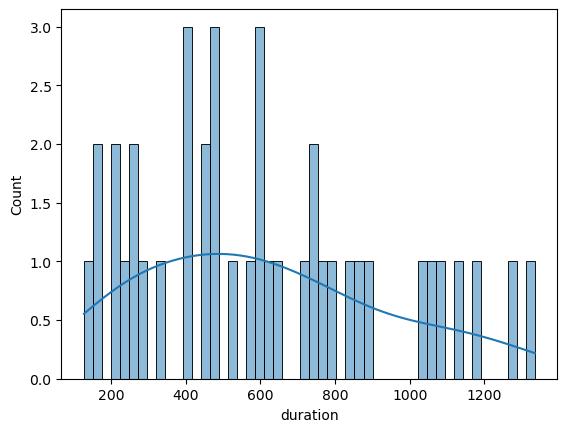

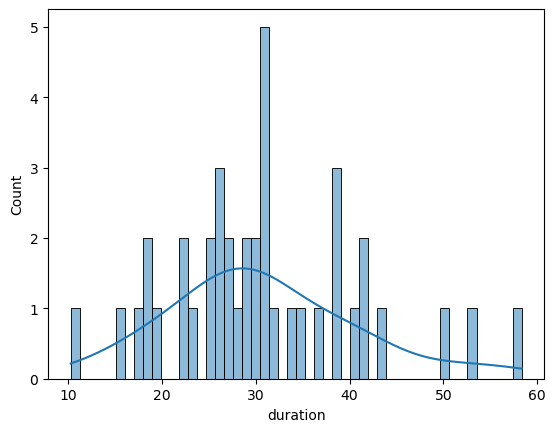

In [56]:
sns.histplot(qLearningData.loc[qLearningData.loc[:,'trialType'] == 0]['duration'], bins=50, kde=True)
plt.show()
sns.histplot(qLearningData.loc[qLearningData.loc[:,'trialType'] == 1]['duration'], bins=50, kde=True)
plt.show()

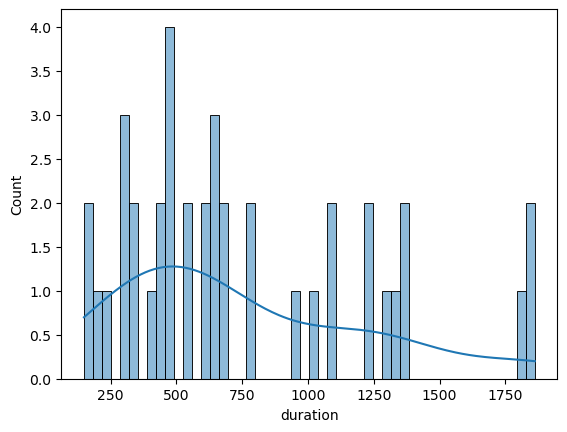

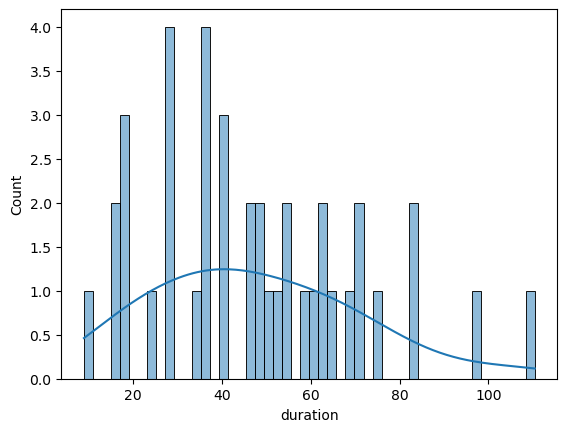

In [57]:
sns.histplot(sarsaData.loc[sarsaData.loc[:,'trialType'] == 0]['duration'], bins=50, kde=True)
plt.show()
sns.histplot(sarsaData.loc[sarsaData.loc[:,'trialType'] == 1]['duration'], bins=50, kde=True)
plt.show()

In [80]:
# env.close()